In [34]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm
from torch import Tensor
from torch.utils.data import DataLoader

from nerf2d import NeRF2D_LightningModule
from nerf2d_dataset import read_image_folder, NeRFDataset2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
ckpt_path = '../checkpoints/last-v1.ckpt'
nerf = NeRF2D_LightningModule.load_from_checkpoint(ckpt_path).to('cpu')

In [36]:
# read test set
dataset_folder = Path('../data/cube')
ims, poses, focal, depths = read_image_folder(dataset_folder / 'test')
dataset = NeRFDataset2D(ims, poses, focal, depths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [37]:
def show_colors(colors, names=None):
    if names is None:
        names = [''] * len(colors)

    fig, ax = plt.subplots(1, len(colors), figsize=(len(colors), 1))
    for i, color in enumerate(colors):
        ax[i].imshow(color.expand(1, 1, 3).detach().numpy())
        ax[i].set_axis_off()
        ax[i].set_title(names[i])

    plt.show()

def get_nth_batch(n, loader):
    for i, batch in enumerate(loader):
        if i == n:
            return batch

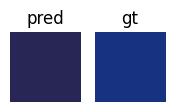

Text(0, 0.5, 'weight')

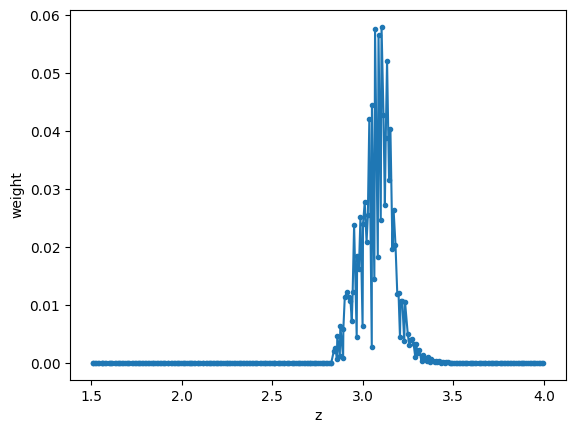

In [43]:
from einops import einsum

ray_idx = 20

# get dataset entry
o, d, color_gt, depth_gt = get_nth_batch(ray_idx, dataloader)

# nerf forward pass
with torch.no_grad():
    outs = nerf(o, d)
    color_pred = outs['colors']
    depth_pred = outs['depths']
    ts = outs['ts']
    weights = outs['weights']
    

# ray color
show_colors([color_pred[0], color_gt[0]], ['pred', 'gt'])

fig, ax = plt.subplots()

# plot weights
ax.plot(ts, weights[0], label='weights', marker='.')
ax.set_xlabel('z')
ax.set_ylabel('weight')



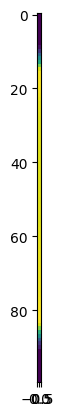

In [85]:
c2w = poses[0]

depth = nerf.render_view(height=100, focal_length_px=focal, c2w=c2w)['depth']


# plt.imshow(depth.detach().numpy())
# plt.imshow(depths[0, 0])